# **ReAct: Build Reasoning and Acting AI Agents with LangGraph**


You're a software engineer on a mission: build an AI agent that doesn't just respond—it thinks. In this lab, you'll step into the role of an AI architect, designing a smart assistant that solves tough problems by reasoning through them and taking purposeful actions.

Using the ReAct (Reasoning + Acting) framework, you'll teach your agent to think step by step, consult tools like search engines or calculators, and adapt on the fly. It’s not just about answers—it’s about how the agent gets there.

By the end of the lab, your AI will face a mystery that can’t be solved with knowledge alone. It will need logic, resourcefulness, and the ability to act—just like you, the engineer who built it.

## What is ReAct?

**ReAct** stands for **Reasoning + Acting**. It's a framework that combines:

1. **Reasoning**: The agent thinks through problems step by step, maintaining an internal dialogue about what it needs to do.
2. **Acting**: The agent can use external tools (search engines, calculators, APIs) to gather information or perform actions.
3. **Observing**: The agent processes the results from its actions and incorporates them into its reasoning.

This creates a powerful loop: **Think → Act → Observe → Think → Act → ...**

### Why ReAct Matters

Traditional language models are limited by their training data cutoff and can't access real-time information. ReAct agents overcome this by:
- Accessing current information through web searches
- Performing calculations with specialized tools
- Breaking down complex problems into manageable steps
- Adapting their approach based on intermediate results


In [29]:
import os, json
from langchain_core.tools import tool
from langchain_groq import ChatGroq
from langchain_tavily import TavilySearch
from typing import TypedDict, Annotated, Literal, List
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage, SystemMessage, BaseMessage
from IPython.display import Image, Markdown
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from dotenv import load_dotenv

_ = load_dotenv()  # take environment variables from .env.

In [30]:
search = TavilySearch()
llm = ChatGroq(model="openai/gpt-oss-120b", temperature=0)

In [31]:
@tool
def search_tool(query: str) -> str:
    """
    Search the web for information using Tavily API.

    :param query: The search query string
    :return: Search results related to the query
    """
    
    return search.invoke(query)

In [32]:
search_tool.invoke("What is LangGraph?")

{'query': 'What is LangGraph?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.datacamp.com/tutorial/langgraph-tutorial',
   'title': 'LangGraph Tutorial: What Is LangGraph and How to Use It?',
   'content': 'LangGraph is a library within the LangChain ecosystem that provides a framework for defining, coordinating, and executing multiple LLM agents (or chains) in a structured and efficient manner. By managing the flow of data and the sequence of operations, LangGraph allows developers to focus on the high-level logic of their applications rather than the intricacies of agent coordination. Whether you need a chatbot that can handle various types of user requests or a multi-agent system that performs complex tasks, LangGraph provides the tools to build exactly what you need. LangGraph significantly simplifies the development of complex LLM applications by providing a structured framework for managing state and coordinating agent interactio

In [33]:
@tool
def recommend_clothing(weather: str) -> str:
    """
    Returns a clothing recommendation based on the provided weather description.

    This function examines the input string for specific keywords or temperature indicators 
    (e.g., "snow", "freezing", "rain", "85°F") to suggest appropriate attire. It handles 
    common weather conditions like snow, rain, heat, and cold by providing simple and practical 
    clothing advice.

    :param weather: A brief description of the weather (e.g., "Overcast, 64.9°F")
    :return: A string with clothing recommendations suitable for the weather
    """
    weather = weather.lower()
    if "snow" in weather or "freezing" in weather:
        return "Wear a heavy coat, gloves, and boots."
    elif "rain" in weather or "wet" in weather:
        return "Bring a raincoat and waterproof shoes."
    elif "hot" in weather or "85" in weather:
        return "T-shirt, shorts, and sunscreen recommended."
    elif "cold" in weather or "50" in weather:
        return "Wear a warm jacket or sweater."
    else:
        return "A light jacket should be fine."

In [34]:
tools = [search_tool, recommend_clothing]
llm_with_tools = llm.bind_tools(tools)

In [35]:
class ChatState(TypedDict):
    messages: Annotated[List[BaseMessage], add_messages]

In [40]:
def chat_node(state: ChatState):
    """LLM node that may answer or request a tool call."""
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

In [37]:
tool_node = ToolNode(tools)

In [43]:
checkpoint = MemorySaver()

In [44]:
graph = StateGraph(ChatState)

graph.add_node("chat_node", chat_node)
graph.add_node("tools", tool_node)

graph.add_edge(START, "chat_node")
graph.add_conditional_edges("chat_node", tools_condition)
graph.add_edge("tools", "chat_node")

workflow = graph.compile(checkpointer=checkpoint)

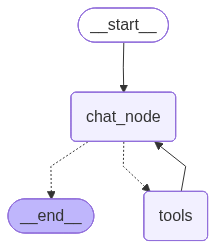

In [45]:
Image(workflow.get_graph().draw_mermaid_png())

In [51]:
config = { 'configurable': { 'thread_id': '1' } }
initial_state = { "messages": [HumanMessage(content="what is the weather of karachi?")] }
final_state = workflow.invoke(initial_state, config=config)

In [53]:
Markdown(final_state["messages"][-1].content)

**Current weather in Karachi (as of 18:00 local time, 29 Sept 2025)**  
- **Condition:** Misty  
- **Temperature:** 37.3 °C (99.1 °F) – feels like ≈ 39 °C (102 °F)  
- **Humidity:** 27 % (relatively low, but the mist can make it feel a bit damp)  
- **Wind:** ≈ 15 km/h (WSW)  
- **UV index:** Very low (0.1) – the mist is blocking much of the sun today.

---

### Clothing recommendation

Even though it’s misty, the temperature is extremely hot, so you’ll want to stay cool and protected:

| What to wear | Why |
|--------------|-----|
| **Light, breathable fabrics** – cotton, linen, or moisture‑wicking synthetics | They let air circulate and help sweat evaporate, keeping you cooler. |
| **Short‑sleeve shirts / loose‑fit tops** | Less insulation, reduces heat buildup. |
| **Shorts, skirts, or lightweight trousers** | Keeps legs cool while still providing modesty. |
| **Wide‑brimmed hat or cap** | Shields your face from any stray sun rays that break through the mist. |
| **Sunglasses** | Even with mist, bright reflections can be harsh on the eyes. |
| **Sunscreen (SPF 30 or higher)** | UV is low now, but it can spike if the mist clears; better safe than sorry. |
| **Comfortable sandals or breathable shoes** | Keeps feet from overheating. |
| **Stay hydrated** – carry a water bottle; consider a light, reusable cooler bag for drinks. |
| **Optional: Light, breathable scarf or shawl** | If you’re moving between indoor air‑conditioned spaces and the outdoors, a thin scarf can help you adjust to temperature changes without overheating. |

**What to avoid:** Heavy jackets, thick denim, or anything that traps heat. Even though it’s misty, the “feels‑like” temperature is near 40 °C, so staying light and airy is key.